<a href="https://colab.research.google.com/github/bdoma97/diplomamunka/blob/main/god_is_the_answer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


https://github.com/krishnaik06/Tomato-Leaf-Disease-Prediction/blob/master/Transfer%20Learning%20Inception%20V3.ipynb






In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

!ln -s /content/gdrive/My\ Drive/_75_all /mydrive
!ls /mydrive

Mounted at /content/gdrive
legszives_3_06	legyszives_2	    legyszives_3_256_7	validation
legyszives	legyszives_3_256_5  train


In [2]:
#!pip install -q tensorflow==2.0.0b1
!pip install -q tensorflow==2.2
import tensorflow as tf

     |████████████████████████████████| 516.2MB 34kB/s 
     |████████████████████████████████| 460kB 47.8MB/s 
     |████████████████████████████████| 3.0MB 48.5MB/s 


In [3]:
print("\nTensorflow Version: " + tf.__version__)
!nvidia-smi -L


Tensorflow Version: 2.2.0
GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-d20baf74-f240-87f8-06c7-d2f701c26eff)


In [81]:
import keras
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.vgg16 import VGG16
# load the model
#IMAGE_SIZE = [224, 224]
#IMAGE_SIZE = [299, 299]
#IMAGE_SIZE = [32, 32]
IMAGE_SIZE = [75, 75]
model = keras.models.load_model('gdrive/MyDrive/_75_all/legyszives_256_7/last_epoch_090_model.h5')
model.summary()
#model = InceptionResNetV2(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)
#model = VGG16(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 37, 37, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 37, 37, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 37, 37, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [60]:
print(len(model.layers))
print(model.layers[783])
print(model.layers[782])
print(model.layers[781])
print(model.layers[780])
print(model.layers[774])

784


In [82]:
i = 0
for layer in model.layers:
  if layer.name == 'block8_10_mixed':
    print(i)
  i += 1

774


In [83]:
for layer in model.layers[774:]:
    layer.trainable = True

In [30]:
from glob import glob

#átalakítás
folders = glob('gdrive/MyDrive/_75_all/train/*')
folders_ = []
for i in range(len(folders)):
  folders_.append(folders[i].split('/')[4])
print(folders_)
folders = []
folders = folders_.copy()
print(folders)

['A', 'C', 'D', 'B', 'F', 'E', 'H', 'J', 'K', 'I', 'L', 'G', 'M', 'N', 'O', 'P', 'R', 'Q', 'S', 'T', 'U', 'W', 'V', 'Y', 'X', 'Z']
['A', 'C', 'D', 'B', 'F', 'E', 'H', 'J', 'K', 'I', 'L', 'G', 'M', 'N', 'O', 'P', 'R', 'Q', 'S', 'T', 'U', 'W', 'V', 'Y', 'X', 'Z']


In [ ]:
!ls /mydrive

legszives_3_06	legyszives_2	    legyszives_3_256_7	validation
legyszives	legyszives_3_256_5  train


In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Activation, Dropout
from tensorflow.keras.models import Model

x = Flatten()(model.output)
dense = Dense(1024, activation='relu')(x)
dropout = Dropout(0.5)(dense)

In [ ]:
prediction = Dense(len(folders), activation='softmax')(dropout)

# create a model object
model_ = Model(inputs=model.input, outputs=prediction)

In [84]:
model_ = model
model_.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 37, 37, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 37, 37, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 37, 37, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [86]:
#opt = keras.optimizers.Adam(learning_rate=0.0001) #normal tanitas 1e-4
#opt = keras.optimizers.Adam(learning_rate=0.00001) #fine tuning section_2 1e-5
opt = keras.optimizers.Adam(learning_rate=1e-6) #1e-6
model_.compile(
  loss='categorical_crossentropy',
  optimizer=opt,
  metrics=['accuracy']
)

In [87]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.1,
                                   zoom_range = 0.1,
                                   horizontal_flip = False)

validation_datagen = ImageDataGenerator(rescale = 1./255)

In [88]:
training_set = train_datagen.flow_from_directory('gdrive/MyDrive/_75_all/train',
                                                 target_size = (75, 75),
                                                 batch_size = 128,
                                                 class_mode = 'categorical')

Found 5400 images belonging to 26 classes.


In [ ]:
print(len(training_set))

43


In [89]:
validation_set = validation_datagen.flow_from_directory('gdrive/MyDrive/_75_all/validation',
                                            target_size = (75, 75),
                                            batch_size = 128,
                                            class_mode = 'categorical')

Found 2700 images belonging to 26 classes.


In [90]:
from keras.callbacks import ModelCheckpoint

#checkpoint = ModelCheckpoint("gdrive/MyDrive/InceptionResNetV2_Characters/best_model.h5", monitor='loss', verbose=1,
#    save_best_only=True, mode='auto', save_freq=1, save_weights_only=False)
checkpoint_last = ModelCheckpoint("gdrive/MyDrive/_75_all/fine_tuning_section_2_1e6/last_epoch_{epoch:03d}_model.h5", monitor='loss', verbose=2,
    save_best_only=False, mode='auto', save_freq='epoch', save_weights_only=False)

In [91]:
r = model_.fit(
  training_set,
  validation_data=validation_set,
  epochs=100,
  steps_per_epoch=len(training_set),
  validation_steps=len(validation_set),
  callbacks=[checkpoint_last]
)
print(r.history)

Epoch 1/100
43/43 [==============================] - ETA: 0s - loss: 0.4500 - accuracy: 0.8859
Epoch 00001: saving model to gdrive/MyDrive/_75_all/fine_tuning_section_2_1e6/last_epoch_001_model.h5
43/43 [==============================] - 26s 599ms/step - loss: 0.4500 - accuracy: 0.8859 - val_loss: 0.8133 - val_accuracy: 0.7800
Epoch 2/100
43/43 [==============================] - ETA: 0s - loss: 0.4332 - accuracy: 0.8898
Epoch 00002: saving model to gdrive/MyDrive/_75_all/fine_tuning_section_2_1e6/last_epoch_002_model.h5
43/43 [==============================] - 22s 520ms/step - loss: 0.4332 - accuracy: 0.8898 - val_loss: 0.8654 - val_accuracy: 0.7674
Epoch 3/100
43/43 [==============================] - ETA: 0s - loss: 0.4161 - accuracy: 0.8926
Epoch 00003: saving model to gdrive/MyDrive/_75_all/fine_tuning_section_2_1e6/last_epoch_003_model.h5
43/43 [==============================] - 23s 531ms/step - loss: 0.4161 - accuracy: 0.8926 - val_loss: 0.9165 - val_accuracy: 0.7600
Epoch 4/100
4

In [ ]:
print(r.history['loss'])
print(r.history['accuracy'])

[1.9085264205932617, 0.9768309593200684, 0.7256008386611938, 0.5952892899513245, 0.5114166736602783, 0.4691370129585266, 0.4182499945163727, 0.3848291337490082, 0.3608781695365906, 0.341860830783844, 0.31832727789878845, 0.31268513202667236, 0.296081006526947, 0.28656327724456787, 0.26318681240081787, 0.2618156671524048, 0.25045108795166016, 0.23872599005699158, 0.24074770510196686, 0.2240673154592514, 0.21710409224033356, 0.21722185611724854, 0.20556150376796722, 0.20488829910755157, 0.19531504809856415, 0.18846046924591064, 0.1883203536272049, 0.18715083599090576, 0.1845439225435257, 0.17362940311431885, 0.17008323967456818, 0.17286671698093414, 0.16666506230831146, 0.16058188676834106, 0.15750914812088013, 0.1590677946805954, 0.15285490453243256, 0.14814989268779755, 0.1496449112892151, 0.14824596047401428, 0.14858800172805786, 0.14524170756340027, 0.135660782456398, 0.13769951462745667, 0.13364234566688538, 0.13149793446063995, 0.13034193217754364, 0.1279524713754654, 0.12893085181

In [ ]:
print(r.history['val_loss'])
print(r.history['val_accuracy'])

[1.9998191595077515, 1.6927993297576904, 1.4844815731048584, 1.3390321731567383, 1.2366867065429688, 1.1657110452651978, 1.116183876991272, 1.0675863027572632, 1.043502926826477, 1.0318470001220703, 1.0134961605072021, 0.9906436204910278, 0.9745992422103882, 0.9555521011352539, 0.9545488953590393, 0.9391052722930908, 0.9159327745437622, 0.9124109148979187, 0.8976300954818726, 0.886425256729126, 0.8877922296524048, 0.8884851336479187, 0.8728365302085876, 0.863139271736145, 0.8739933967590332, 0.8481064438819885, 0.8501020073890686, 0.850752592086792, 0.8321983218193054, 0.8207629919052124, 0.821471095085144, 0.8329843282699585, 0.8196668028831482, 0.8142215609550476, 0.8199590444564819, 0.8112879991531372, 0.8143974542617798, 0.8201663494110107, 0.8201984763145447, 0.8239282369613647, 0.810157060623169, 0.8172003626823425, 0.8185522556304932, 0.8224517107009888, 0.8129808902740479, 0.8138994574546814, 0.8083236813545227, 0.8111193180084229, 0.804423451423645, 0.8052197098731995, 0.81631

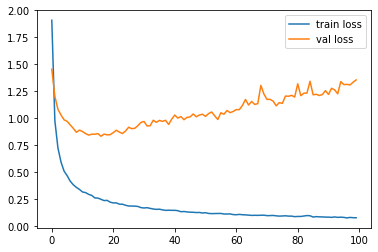

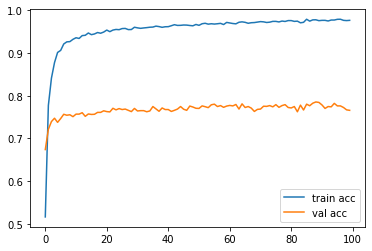

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt


# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
for i in r.history['val_accuracy']:
  print(i)

0.6474074125289917
0.70333331823349
0.7118518352508545
0.7122222185134888
0.7059259414672852
0.7162963151931763
0.7196296453475952
0.7192592620849609
0.7170370221138
0.7277777791023254
0.7259259223937988
0.7337037324905396
0.7229629755020142
0.732962965965271
0.7392592430114746
0.737407386302948
0.7418518662452698
0.745555579662323
0.7396296262741089
0.7381481528282166
0.7481481432914734
0.7433333396911621
0.7474074363708496
0.7585185170173645
0.7537037134170532
0.746666669845581
0.745555579662323
0.7381481528282166
0.7525925636291504
0.7396296262741089
0.7614814639091492
0.7396296262741089
0.7366666793823242
0.7355555295944214
0.7481481432914734
0.7566666603088379
0.7607407569885254
0.75
0.7507407665252686
0.7607407569885254
0.7611111402511597
0.7651851773262024
0.7596296072006226
0.7548148036003113
0.7570370435714722
0.7551851868629456
0.7585185170173645
0.7440740466117859
0.742222249507904
0.7607407569885254
0.7562962770462036
0.7451851963996887
0.7522222399711609
0.7585185170173645

In [ ]:

# save it as a h5 file


from tensorflow.keras.models import load_model

model_.save('best_model.h5')
model_ = keras.models.load_model("gdrive/MyDrive/InceptionResNetV2_Characters/modellek/best_model.h5")
model_.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 37, 37, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 37, 37, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 37, 37, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
from keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
# load an image from file
image = load_img('10.png', target_size=(75,75))
plt.show()
print(image)


<PIL.PngImagePlugin.PngImageFile image mode=RGB size=75x75 at 0x7F6ABEB7B810>


<class 'PIL.Image.Image'>


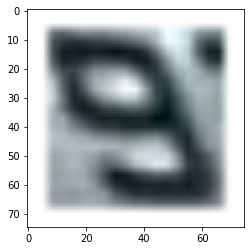

In [ ]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import img_to_array, array_to_img
# convert the image pixels to a numpy array
image = img_to_array(image)
image_ = array_to_img(image)
print(type(image_))
plt.imshow(image_)
plt.show()

In [ ]:
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
from keras.applications.inception_resnet_v2 import preprocess_input
image = preprocess_input(image)
yhat = model_.predict(image)

In [ ]:
print(yhat)
print(type(yhat))
print(len(yhat))
yhat_ = yhat.tolist()
for i in yhat_:
  print(i)

[[6.8836312e-23 2.3559664e-27 4.1339437e-08 3.4801767e-10 7.8328555e-23
  5.8451235e-09 5.0911117e-06 5.2137748e-13 5.1278900e-04 9.9948210e-01]]
<class 'numpy.ndarray'>
1
[6.883631182306034e-23, 2.3559664120305897e-27, 4.133943676265517e-08, 3.480176702375104e-10, 7.832855518872718e-23, 5.845123496328597e-09, 5.091111688670935e-06, 5.213774832875384e-13, 0.0005127890035510063, 0.9994820952415466]


In [ ]:
logits_model = tf.keras.Model(model_.input,model_.layers[-1].output)

In [ ]:
logits_model

In [ ]:
!pip install git+https://github.com/tensorflow/cleverhans.git#egg=cleverhans

import cleverhans

  Cloning https://github.com/tensorflow/cleverhans.git to /tmp/pip-install-u_gs1q3j/cleverhans
  Running command git clone -q https://github.com/tensorflow/cleverhans.git /tmp/pip-install-u_gs1q3j/cleverhans
     |████████████████████████████████| 163kB 24.0MB/s 
     |████████████████████████████████| 51kB 8.0MB/s 
  Created wheel for cleverhans: filename=cleverhans-4.0.0-cp37-none-any.whl size=92450 sha256=923b06cb21a2d95f219fc4692b29050537d0cf77e32dc55b1e0225fa4f246f96
  Stored in directory: /tmp/pip-ephem-wheel-cache-3i305xrq/wheels/6e/59/ec/723a6f654aaf62c8c40f0f0850fdf71a4948598697f56c3bfa
Successfully built cleverhans
ERROR: -ensorflow 2.4.1 has requirement gast==0.3.3, but you'll have gast 0.4.0 which is incompatible.
ERROR: -ensorflow 2.4.1 has requirement tensorboard~=2.4, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: -ensorflow 2.4.1 has requirement tensorflow-estimator<2.5.0,>=2.4.0, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
  Found

In [ ]:
from cleverhans.tf2.attacks import fast_gradient_method

In [ ]:
model_.summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
___________________________________________________________________________________________

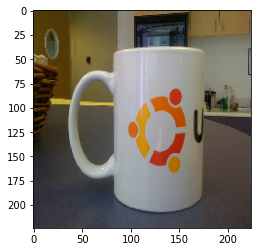

99.99995231628418
4.303192042698356e-05
1.07507949209662e-06
KURVA ANYÁD

80.37685751914978
19.623103737831116
3.788808271565358e-05
KURVA ANYÁD

62.147724628448486
37.852248549461365
3.244259971779684e-05
KURVA ANYÁD

68.74850392341614
31.251463294029236
3.5729703995457385e-05
KURVA ANYÁD

81.18329048156738
18.81667822599411
3.232482868043007e-05
KURVA ANYÁD

93.71662735939026
6.283354014158249
2.2820769629561255e-05
KURVA ANYÁD

98.12285304069519
1.8771378323435783
9.982466053770622e-06
KURVA ANYÁD

99.5491087436676
0.45088957995176315
4.7165428895823425e-06
KURVA ANYÁD

99.88794922828674
0.11205524206161499
1.6786666279244855e-06
KURVA ANYÁD

99.97380375862122
0.026194698875769973
2.970625079257161e-07
KURVA ANYÁD

99.99082088470459
0.009175514423986897
6.400261987060674e-08
KURVA ANYÁD

99.9961256980896
0.0038747137296013534
2.1314562614893617e-08
KURVA ANYÁD

99.99818801879883
0.0018101607565768063
7.866893941832487e-09
KURVA ANYÁD

99.99908208847046
0.0009216129001288209
4.472178

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
epsilon = 0.01
image_ = np.squeeze(image)
image_ = array_to_img(image_)
plt.imshow(image_)
plt.show()
for i in range(100):
  adv_example_untargeted_label = fast_gradient_method.fast_gradient_method(logits_model, image, epsilon*i, np.inf, targeted=False)
  adv_example_untargeted_label_pred = model_.predict(adv_example_untargeted_label)
  for j in range(3):
    print(adv_example_untargeted_label_pred[0][j]*100)
  print('KURVA ANYÁD')
  print()
  image_ = np.squeeze(adv_example_untargeted_label)
  image_ = array_to_img(image_)
  #plt.imshow(image_)
  #plt.show()